In [1]:
# Standard library imports
from datetime import datetime
import os

# Third-party library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Visualize loop progress
import xlwings as xw # dynamic Excel interaction
from lightweight_charts import Chart
import mplfinance as mpf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Set pandas display options for better data frame visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Segreti
from dotenv import load_dotenv
load_dotenv()

# API
import requests
import json

| Gap-Up Screener |
|--|
TradingView Data (import)

In [2]:
# today's date string for file naming automation
today_date_str = datetime.now().strftime("_%Y-%m-%d.csv")
# today_date_str = '_2024-03-06.csv'

print(today_date_str)

_2024-03-17.csv


In [3]:
# concat base file name with today's date string
filename = f"trading_view_raw_data/tv_screen_gap-up{today_date_str}"
# read in trading view raw data
trading_view_raw_df = pd.read_csv(filename)

print(f'{len(trading_view_raw_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
trading_view_raw_df.head(5)

FileNotFoundError: [Errno 2] No such file or directory: 'trading_view_raw_data/tv_screen_gap-up_2024-03-17.csv'

In [ ]:
def categorize_market_cap(df):
    # convert 'Market capitalization' to numeric, coercing errors to NaN
    df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
    # define conditions for market cap categories
    conditions = [
        # Titans
        (df['Market capitalization'] >= 200000000000),  # 200 billion and above
        #Large Cap
        (df['Market capitalization'] >= 10000000000) & (df['Market capitalization'] < 200000000000),  # 10 billion to 200 billion
        # Midlers
        (df['Market capitalization'] >= 2000000000) & (df['Market capitalization'] < 10000000000),  # 2 billion to 10 billion
        # Small Cap
        (df['Market capitalization'] >= 300000000) & (df['Market capitalization'] < 2000000000),  # 300 million to 2 billion
        # Micro Cap
        (df['Market capitalization'] > 50000000) & (df['Market capitalization'] < 300000000),  # 300 million and below (excluding 50 million and below)
        # Shrimp
        (df['Market capitalization'] <= 50000000)  # 50 million and below
    ]
    categories = ['Titans', 'Large caps', 'Midlers', 'Small caps', 'Micro caps', 'Shrimp']
    # use np.select to assign categories based on conditions
    df['marketCapType'] = np.select(conditions, categories, default='Undefined')
    
    return df


In [ ]:
# EXECUTE
trading_view_raw_df = categorize_market_cap(trading_view_raw_df)
trading_view_raw_df.head(5)

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,TSLA,"Tesla, Inc.",NASDAQ,5.209362e+11,USD,163.57,USD,163.00,USD,0.73,USD,0.449231,0.307692,2770369201.25,96098163,501731589.0,1473149,105130292.60000014,102063035.89999989,111980960.5111112,2.752239,4.612811,4.394795,163.171500,38.01124744,Consumer Durables,0.84175082,1.9440945,1.8757325,2.4145472,2.191866,2.248057,1.965164,1.351116,0.526402,0.26871086,0.51752279,0.92629389,1.00422015,0.44686547,205.600,USD,265.130,USD,273.930,USD,299.290,USD,414.496253,USD,163.7787,USD,163.7787,USD,163.7787,USD,163.7787,USD,163.7787,USD,163.89,USD,165.1845,USD,182.8700,USD,204.520,USD,688908.18876225,USD,163.53558,163.451000,163.175,163.205492,163.737746,163.166655,162.595564,163.947332,163.227280,162.507228,Titans
1,COST,Costco Wholesale Corporation,NASDAQ,3.218198e+11,USD,725.63,USD,735.00,USD,1.39,USD,0.189904,0.416695,441382276.864,3278890,14865132.0,17750,3453023.7,2374784.43333333,2234222.66666667,1.285916,2.316285,1.602446,727.123333,47.47458226,Retail Trade,0.83971587,0.72389096,1.0365967,0.7653925,5.833123,7.874471,7.215758,5.131536,1.217656,0.82267842,0.44188516,0.9957313,1.44874562,0.92308867,787.080,USD,787.080,USD,787.080,USD,787.080,USD,787.080000,USD,726.2100,USD,726.4500,USD,728.0000,USD,728.0000,USD,728.0000,USD,729.17,USD,732.5200,USD,740.6754,USD,787.080,USD,766740.50632911,USD,725.51000,725.450625,726.187,727.408462,727.242501,725.972000,724.701499,729.622860,727.584250,725.545640,Titans
2,TM,Toyota Motor Corporation,NYSE,3.146256e+11,USD,234.62,USD,235.14,USD,4.22,USD,1.827077,1.805429,1348583643.52732,178926,1325217.0,200,299147.2,347124.56666667,310033,1.776998,1.121998,1.000134,234.426667,10.00635473,Consumer Durables,0.45083634,1.0406966,0.83865297,0.71434224,10.662666,4.584395,4.628748,3.783469,1.246232,0.6101208,0.43810286,0.56781409,0.86859059,0.51641414,253.425,USD,253.425,USD,253.425,USD,253.425,USD,253.425000,USD,234.8900,USD,234.8900,USD,234.8900,USD,234.8900,USD,234.8900,USD,234.89,USD,235.1200,USD,238.4399,USD,253.425,USD,730651.80692042,USD,234.80400,234.821250,234.756,234.740000,234.907518,234.769755,234.631992,234.944137,234.687735,234.431333,Titans
3,NFLX,"Netflix, Inc.",NASDAQ,2.622004e+11,USD,6

In [ ]:
# drop NaNs
tv_df = trading_view_raw_df.dropna()
print(f'NaNs = {tv_df.isna().sum().sum()}')

# confirm no NaNs
if tv_df.isna().sum().sum() == 0:
    nan_count = tv_df.isna().sum().sum()
    print(f"There are zero {nan_count} NaNs in DataFrame! Nice work!")
else:
    print(f"There are {tv_df.isna().sum().sum()} NaNs in DataFrame, check your code dumb dumb!")

NaNs = 0
There are zero 0 NaNs in DataFrame! Nice work!


In [ ]:
# view the raw counts and percentages of each market cap type
market_cap_type_df = trading_view_raw_df['marketCapType'].value_counts().reset_index()
market_cap_type_df.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage -> add new columne to dataframe
market_cap_type_df['percentage'] = (market_cap_type_df['count'] / market_cap_type_df['count'].sum()) * 100

print(f'There are still the same {len(trading_view_raw_df.index)} U.S. Stocks in the dataframe \n$(pre-market change) > $0.00 USD')
market_cap_type_df

There are still the same 1047 U.S. Stocks in the dataframe 
$(pre-market change) > $0.00 USD


,marketCapType,count,percentage
0,Small caps,269,25.692455
1,Shrimp,228,21.776504
2,Micro caps,216,20.630372
3,Large caps,160,15.281757
4,Midlers,154,14.708691
5,Undefined,13,1.241643
6,Titans,7,0.668577


In [ ]:
# print length of df
print(f'{len(tv_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
# print sample head
tv_df.sample(5)

1034 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
380,PMT/PC,PennyMac Mortgage Investment Trust 6.75% Serie...,NYSE,1.220847e+09,USD,19.4000,USD,19.4000,USD,0.0100,USD,0.051573,0.051573,85604996.9184,16010,58699.0,104,14719.1,15737.96666667,19294.61111111,0.670625,1.143155,1.385906,19.423300,12.03623278,Finance,-,1.1006497,0.95735043,0.95735043,0.159109,0.159109,7.710508,2.644823,1.841423,1.28504414,0.82630294,1.0542605,0.80106283,0.36084763,20.1466,USD,20.1466,USD,20.1466,USD,20.1466,USD,26.2000,USD,19.4000,USD,19.4000,USD,19.4000,USD,19.4000,USD,19.4000,USD,19.4000,USD,19.4999,USD,19.4999,USD,19.6500,USD,240228000,USD,19.39594,19.394925,19.39594,19.390531,19.456635,19.402025,19.347415,19.476203,19.405535,19.334867,Small caps
657,OMGA,"Omega Therapeutics, Inc.",NASDAQ,1.996135e+08,USD,3.6200,USD,3.5400,USD,0.1000,USD,2.832861,0.283286,20415865.4574,302177,1440518.0,420,345458.4,488666.56666667,1571334.14444444,4.775281,6.708360,7.784441,3.626667,-,Health Technology,0.7642423,1.0047343,1.8760802,1.8760802,7.430003,6.843938,3.331473,2.668163,0.791165,0.4451802,0.57931834,0.79775882,0.10911408,0.2550789,4.4599,USD,6.3000,USD,6.3000,USD,10.0900,USD,31.4100,USD,3.6200,USD,3.6400,USD,3.6400,USD,3.6400,USD,3.6400,USD,3.7000,USD,3.7000,USD,4.2100,USD,4.4599,USD,17717.94871795,USD,3.61286,3.618663,3.61800,3.636438,3.638160,3.621465,3.604770,3.700035,3.649185,3.598335,Micro caps
472,OPK,"Opko Health, Inc.",NASDAQ,6.236682e+08,USD,0.8948,USD,0.8998,USD,0.0242,USD,2.733228,1.626384,329228353.152,9776119,43851433.0,88590,9084963.2,8272415.43333333,9462323.88888889,3.796900,4.301224,5.319719,0.901400,-,Health Services,0.58655931,2.1592584,1.6669918,1.7969451,9.015731,7.953060,2.980076,1.851057,0.662767,0.296071,0.40285371,1.08824256,0.60096231,0.86792297,1.0700,USD,1.6600,USD,1.7000,USD,2.2400,USD,19.2000,USD,0.9013,USD,0.9013,USD,0.9022,USD,0.9022,USD,0.9022,USD,0.9192,USD,0.9192,USD,0.9654,USD,1.0100,USD,219718.82951654,USD,0.89630,0.896524,0.89852,0.902046,0.902454,0.898227,0.894000,0.919364,0.905970,0.892577,Small caps
948,JOAN,"JOANN, Inc.",NASDAQ,9.656445e+06,USD,0.2304,USD,0.2147,USD,0.0237,USD,11.488124,4.071740,11827481.74,1546499,4051229.0,20633,1263061,518421.33333333,330

In [ ]:
# # drop undefined
# tv_df = tv_df[tv_df['marketCapType'] != 'Undefined']

# market_cap_type_df2 = tv_df['marketCapType'].value_counts().reset_index()
# market_cap_type_df2.columns = ['marketCapType', 'count']  # Rename columns for clarity

# # calculate percentage for each market cap type and add it to the DataFrame
# market_cap_type_df2['percentage'] = (market_cap_type_df2['count'] / market_cap_type_df2['count'].sum()) * 100

# market_cap_type_df2
# print(market_cap_type_df2)


In [ ]:
# 1/3 #### CONFIG DATA SECTION ####
criteria_config = {
    "Titans": {
        "pre_market_change_pct_threshold": 0.002,  # Reduced to 0.2% for Titans
        "float_shares_outstanding_threshold": 1000000000,  # Increased to 1 billion shares
        "relative_volume_threshold": 1.2,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.03,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.001,  # Reduced to 0.1%
        "pre_market_vmap_drawdown_threshold": 0.003  # .3% drawdown from VWAP
    },
    "Large caps": {
        "pre_market_change_pct_threshold": 0.005,  # Reduced to 0.5% for Large caps
        "float_shares_outstanding_threshold": 200000000,  # Increased to 200 million shares
        "relative_volume_threshold": 1.3,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.04,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.005,  # Reduced to 0.5%
        "pre_market_vmap_drawdown_threshold": 0.004  # .4% drawdown from VWAP
    },
    "Midlers": {
        "pre_market_change_pct_threshold": 0.02,  # 2% for Mid caps
        "float_shares_outstanding_threshold": 50000000,  # 50 million shares
        "relative_volume_threshold": 1.3,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .02,
        "pre_market_vmap_drawdown_threshold": 0.005  # .5% drawdown from VWAP
    },
    "Small caps": {
        "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
        "float_shares_outstanding_threshold": 20000000,  # 20 million shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .03,
        "pre_market_vmap_drawdown_threshold": 0.006  # 6% drawdown from VWAP
    },
    "Micro caps": {
        "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
        "float_shares_outstanding_threshold": 5000000,  # 5 million shares
        "relative_volume_threshold": 1.1,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .04,
        "pre_market_vmap_drawdown_threshold": 0.007  # 7% drawdown from VWAP
    },
    "Shrimp": {
        "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
        "float_shares_outstanding_threshold": 1000000,  # 1 million shares
        "relative_volume_threshold": 1.0,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .05,
        "pre_market_vmap_drawdown_threshold": 0.008  # 8% drawdown from VWAP
    }
}

# 2/3 #### CORE FUNCTIONS ####
def filter_by_pre_market_change(df, change_pct_threshold):
    """Filter stocks by pre-market change percentage."""
    return df[df['Pre-market Change %'] >= change_pct_threshold]

def filter_by_float_shares(df, float_shares_threshold):
    """Filter stocks by float shares outstanding."""
    # create a copy to safely modify without affecting the original DataFrame
    modified_df = df.copy()
    modified_df['Float shares outstanding'] = pd.to_numeric(modified_df['Float shares outstanding'], errors='coerce')
    return modified_df[modified_df['Float shares outstanding'] <= float_shares_threshold]

def filter_by_relative_volume(df, relative_volume_threshold):
    """Filter stocks by relative volume."""
    df['Relative Volume 1 day'] = pd.to_numeric(df['Relative Volume 1 day'], errors='coerce')
    return df[df['Relative Volume 1 day'] >= relative_volume_threshold]

def filter_by_relative_volume_at_time(df, relative_volume_at_time_threshold):
    """Filter stocks by relative volume at a specific time."""
    # Convert 'Relative Volume at Time' to float
    df['Relative Volume at Time'] = pd.to_numeric(df['Relative Volume at Time'], errors='coerce')
    return df[df['Relative Volume at Time'] >= relative_volume_at_time_threshold]

def filter_by_pre_market_gap_percentage(df, pre_market_gap_percentage_threshold):
    """Filter stocks by pre-market gap percentage."""
    return df[df['Pre-market Gap %'] >= pre_market_gap_percentage_threshold]

def filter_by_price_near_vwap(df, pre_market_vmap_drawdown_threshold):
    """
    Filter stocks where the price is near the VWAP, considering the specified drawdown threshold.
    """
    df_filtered = df.copy()
    df_filtered['Price'] = pd.to_numeric(df_filtered['Price'], errors='coerce')
    df_filtered['Volume Weighted Average Price 1 day'] = pd.to_numeric(df_filtered['Volume Weighted Average Price 1 day'], errors='coerce')
    
    # Calculate the acceptable minimum price based on the VWAP drawdown threshold
    df_filtered['Min Price from VWAP'] = df_filtered['Volume Weighted Average Price 1 day'] * (1 - pre_market_vmap_drawdown_threshold)
    
    # Apply the filter
    df_filtered = df_filtered[df_filtered['Price'] >= df_filtered['Min Price from VWAP']]
    
    return df_filtered.drop(columns=['Min Price from VWAP'])

"""SPECIAL FILTERS"""
def filter_by_volatility(df):
    """Filter stocks based on recent volatility being higher than weekly and monthly averages."""
    # Ensure data types are correct; convert to numeric if necessary
    df['Volatility 1 day'] = pd.to_numeric(df['Volatility 1 day'], errors='coerce')
    df['Volatility 1 week'] = pd.to_numeric(df['Volatility 1 week'], errors='coerce')
    df['Volatility 1 month'] = pd.to_numeric(df['Volatility 1 month'], errors='coerce')
    filtered_df = df[
        (df['Volatility 1 day'] >= df['Volatility 1 week']) & 
        (df['Volatility 1 day'] >= df['Volatility 1 month'])]
    return filtered_df

# 3/3 #### WRAPPER FUNCTION ####
def screen_stocks_by_category(df, category):
    """Screen stocks based on their market cap category."""
    # 3a. Get the configuration for the specified category
    config = criteria_config.get(category, {})
    pre_market_change_pct_threshold = config.get("pre_market_change_pct_threshold", 0)
    float_shares_threshold = config.get("float_shares_outstanding_threshold", float('inf'))
    relative_volume_threshold = config.get("relative_volume_threshold", 0)
    relative_volume_at_time_threshold = config.get("relative_volume_at_time_threshold", 0)
    pre_market_gap_percentage_threshold = config.get("pre_market_gap_percentage_threshold", 0)
    pre_market_vmap_drawdown_threshold = config.get("pre_market_vmap_drawdown_threshold", 0)
    # 3b. Apply the filters
    filtered_df = filter_by_pre_market_change(df, pre_market_change_pct_threshold)
    filtered_df = filter_by_float_shares(filtered_df, float_shares_threshold)
    filtered_df = filter_by_relative_volume(filtered_df, relative_volume_threshold)
    filtered_df = filter_by_relative_volume_at_time(filtered_df, relative_volume_at_time_threshold)
    filtered_df = filter_by_volatility(filtered_df) # SPECIAL FILTER
    # filtered_df = filter_by_price_above_vwap(filtered_df) # SPECIAL FILTER
    filtered_df = filter_by_pre_market_gap_percentage(filtered_df, pre_market_gap_percentage_threshold)
    filtered_df = filter_by_price_near_vwap(filtered_df, pre_market_vmap_drawdown_threshold)
  
    # 3c. Return the filtered DataFrame
    return filtered_df

In [ ]:
#EXECUTE
tv_L2_df = pd.DataFrame()
categories = tv_df['marketCapType'].unique()

for category in categories:
    category_df = tv_df[tv_df['marketCapType'] == category]
    screened_df = screen_stocks_by_category(category_df, category)
    tv_L2_df = pd.concat([tv_L2_df, screened_df])

# Display results
print(f'Original DataFrame length: {len(tv_df.index)}')
print(f'Number of rows removed: {len(tv_df.index) - len(tv_L2_df.index)}')
print(f'NEW DataFrame length: {len(tv_L2_df.index)}')

# filter in descending order by market cap and then by pre-market change percentage
tv_L2_df = tv_L2_df.sort_values(by=['Market capitalization', 'Pre-market Change %'], ascending=[False, False])
# reset index and drop
tv_L2_df = tv_L2_df.reset_index(drop=True)

Original DataFrame length: 1034
Number of rows removed: 1018
NEW DataFrame length: 16


In [ ]:
# create a breakdown of the market cap types
market_cap_type_df3 = tv_L2_df['marketCapType'].value_counts().reset_index()
market_cap_type_df3.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage for each market cap type and add it to the DataFrame
market_cap_type_df3['percentage'] = (market_cap_type_df3['count'] / market_cap_type_df3['count'].sum()) * 100

print('Returned Gap-Up Market Cap Type Groups:')
market_cap_type_df3

Returned Gap-Up Market Cap Type Groups:


,marketCapType,count,percentage
0,Large caps,7,43.75
1,Small caps,6,37.50
2,Midlers,3,18.75


In [ ]:
### ADD 'TSLA' TO THE DATAFRAME ####


In [ ]:
# market cap type groups
print(f"Market Cap Groups:\n{tv_L2_df['marketCapType'].unique()}\n")

# TradingView column names
tv_raw_columns_list = tv_L2_df.columns.tolist()
print(f'TradingView Column Names (raw data):\n{tv_raw_columns_list}\n')

# stocks returned from the pre-market gap up screener
print(f'{len(tv_L2_df.index)} = U.S. stocks returned from the pre-market gap up screener.')

# create a list of 'Symbols' from the tv_L2_df
gap_up_stocks_list = tv_L2_df['Symbol']
gap_up_stocks_list = gap_up_stocks_list.tolist()
print(gap_up_stocks_list)

# FILTERD DATAFRAME WITH GAP-UP STOCK TARGETS
tv_L2_df


Market Cap Groups:
['Large caps' 'Midlers' 'Small caps']

TradingView Column Names (raw data):
['Symbol', 'Description', 'Exchange', 'Market capitalization', 'Market capitalization - Currency', 'Price', 'Price - Currency', 'Pre-market Open', 'Pre-market Open - Currency', 'Pre-market Change', 'Pre-market Change - Currency', 'Pre-market Change %', 'Pre-market Gap %', 'Float shares outstanding', 'Volume 1 day', 'Volume 1 week', 'Pre-market Volume', 'Average Volume 10 days', 'Average Volume 30 days', 'Average Volume 90 days', 'Volatility 1 day', 'Volatility 1 week', 'Volatility 1 month', 'Volume Weighted Average Price 1 day', 'Price to earnings ratio', 'Sector', 'Relative Volume at Time', 'Beta 1 year', 'Beta 3 years', 'Beta 5 years', 'Relative Volume 1 minute', 'Relative Volume 5 minutes', 'Relative Volume 15 minutes', 'Relative Volume 30 minutes', 'Relative Volume 1 hour', 'Relative Volume 2 hours', 'Relative Volume 4 hours', 'Relative Volume 1 day', 'Relative Volume 1 week', 'Relative V

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,SCCO,Southern Copper Corporation,NYSE,7.963066e+10,USD,103.00,USD,98.970,USD,2.470,USD,2.541675,1.841943,8.510273e+07,3585934,11217057.0,7325,1657175.9,1100764.43333333,1036549.07777778,6.475766,3.615999,2.563267,101.803333,32.83391776,Non-Energy Minerals,2.194055,1.2943223,1.1742655,1.2757876,14.937465,22.492020,13.827093,6.569379,3.021643,1.30283499,1.39887341,2.622875,2.63502422,0.80394232,103.5800,USD,103.5800,USD,103.5800,USD,103.5800,USD,103.580000,USD,103.010,USD,103.010,USD,103.010,USD,103.010,USD,103.010,USD,103.5800,USD,103.5800,USD,103.5800,USD,103.5800,USD,625920.30360531,USD,102.6400,102.670000,102.86450,102.844431,103.059952,102.734125,102.408298,103.292978,102.945925,102.598872,Large caps
1,STLD,"Steel Dynamics, Inc.",NASDAQ,2.180952e+10,USD,137.90,USD,133.260,USD,0.510,USD,0.385896,0.832324,1.479518e+08,2945998,6970828.0,6725,1191518.7,1161731.63333333,1261988.42222222,5.568303,3.318043,2.882291,136.156333,9.44934766,Non-Energy Minerals,2.028749,0.89790493,1.5069118,1.4185534,5.767468,9.647061,7.500700,5.397478,2.391079,1.51493616,1.7913046,2.811763,1.20111351,0.46622559,138.9490,USD,138.9490,USD,138.9490,USD,138.9490,USD,138.949000,USD,138.270,USD,138.880,USD,138.949,USD,138.949,USD,138.949,USD,138.9490,USD,138.9490,USD,138.9490,USD,138.9490,USD,1491691.74603175,USD,137.9600,137.976875,138.51800,138.508077,139.221635,138.402595,137.583555,138.967501,138.436160,137.904819,Large caps
2,GPC,Genuine Parts Company,NYSE,2.142379e+10,USD,153.66,USD,155.750,USD,3.880,USD,2.554817,2.554817,1.390629e+08,1608247,5788145.0,100,1056652,1173310.93333333,1020929.28888889,2.469218,1.422450,1.729521,153.170000,16.46380663,Distribution Services,1.121906,1.0652641,0.7755743,0.9448018,6.067152,5.480205,6.170010,4.915043,2.035032,1.25953687,0.96321745,1.592435,1.19739308,0.5762271,154.9100,USD,154.9100,USD,154.9100,USD,174.9100,USD,187.725000,USD,153.955,USD,154.080,USD,154.330,USD,154.330,USD,154.330,USD,154.6200,USD,154.7900,USD,154.9100,USD,154.9100,USD,384843.5,USD,153.7125,153.774063,153.89600,154.103077,154.023746,153.816540,153.609334,154.611346,154.191500,153.771654,Large caps
3,LOGI,Logitech International S.A. - R

| Gap-Up Screener |
|--|
IEX Cloud API (GET Request)

In [ ]:
"""
A.
THIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))
-try to get foreign news where people are awake
-translation (internationalization) feature would be both advanced as well as practical
-all info about these companies so we start to learn what we are wokring with today
-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade

B.
-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.
-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?

C.
-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)

"""

"\nA.\nTHIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))\n-try to get foreign news where people are awake\n-translation (internationalization) feature would be both advanced as well as practical\n-all info about these companies so we start to learn what we are wokring with today\n-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade\n\nB.\n-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.\n-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?\n\nC.\n-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)\n\n"

In [ ]:
# """NEWS AND THAT INTERNATIONALIZATION SHIT GOES HERE"""
# info_news_df = pd.DataFrame(tv_L2_df, columns=['Symbol', 'Exchange', 'marketCapType'])

# info_news_df

In [ ]:
# # manual add list
# manual_add_list = ['DELL','PLTR','TSLA']
# # append list with manually added stocks
# gap_up_stocks_list.extend(manual_add_list)

# print(f'{manual_add_list} added manually\n')
# print(f'New list: {gap_up_stocks_list}')

In [ ]:
#### IEX CLOUD API KEY -> VARIABLE ####
iex_api_key = os.getenv("IEX_API_KEY")

# set the list of symbols variable
symbols = ','.join(gap_up_stocks_list)

# SETTING THE DATE RANGE
"""
y - Example: range=1y -> returns (one year)
ytd - Example: range=ytd -> returns (year-to-date)
m - Example: range=6m returns (six months)
d - Example: range=5d returns (five days)
"""
data_range = '5m' # DATE RANGE (for historical stock price data)

url = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={symbols}&types=chart&range={data_range}&token={iex_api_key}'

# Make the GET request
response = requests.get(url)

# Initialize a list to collect DataFrames for each symbol
dataframes_list = []

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to JSON
    data = response.json()

    # Process and print the data with a progress bar
    for symbol in tqdm(gap_up_stocks_list, desc="Processing symbols"):
        if symbol in data:
            # Create a DataFrame for the current symbol's data
            symbol_df = pd.DataFrame(data[symbol]['chart'])
            # Add a 'Ticker' column to identify the data
            symbol_df['Ticker'] = symbol
            # Append the current symbol's DataFrame to the list
            dataframes_list.append(symbol_df)
            # print(f'Data for {symbol}:')
            # print(symbol_df.head(5))  # print the first few rows of the DataFrame for this symbol
else:
    print(f'Failed to fetch data: {response.status_code}')

# concatenate dataframes and create a combined list
historical_df = pd.concat(dataframes_list, ignore_index=True)


Processing symbols: 100%|██████████| 16/16 [00:00<00:00, 1361.37it/s]


In [ ]:
# Set variables for historical data analysis
historical_length = len(historical_df.index)
unique_stocks = historical_df['Ticker'].nunique()
start_date = historical_df['date'].min()
end_date = historical_df['date'].max()

print(f"START date: {start_date}")
print(f"END date: {end_date}")
print(f'{historical_df["date"].nunique()} days of historical stock data.\n')
print(f"{historical_length} = Length of dataframe")
print(f"{unique_stocks} = Unique stocks in dataframe")

# Entries per stock
days_per_stock = historical_length / unique_stocks
print(f"{days_per_stock} = Date entries per stock (MATH check -> should be the same as the unique )\n")

# View the stocks
print(f'Unique stock ticker symbols: {gap_up_stocks_list}')
historical_cols_list = historical_df.columns.tolist()
print(f'Columns: {historical_cols_list}')

# convert df to .csv
# historical_df.to_csv(f'historical_stock_data{today_date_str}.csv', index=False)

# Display the first few rows of the dataframe
historical_df.tail(10)

START date: 2023-10-16
END date: 2024-03-14
104 days of historical stock data.

1625 = Length of dataframe
16 = Unique stocks in dataframe
101.5625 = Date entries per stock (MATH check -> should be the same as the unique )

Unique stock ticker symbols: ['SCCO', 'STLD', 'GPC', 'LOGI', 'WES', 'DINO', 'PAYC', 'AXSM', 'DYN', 'SWI', 'ECO', 'SCVL', 'MBUU', 'DRCT', 'ONEW', 'BOOM']
Columns: ['close', 'high', 'low', 'open', 'priceDate', 'symbol', 'volume', 'id', 'key', 'subkey', 'date', 'updated', 'changeOverTime', 'marketChangeOverTime', 'uOpen', 'uClose', 'uHigh', 'uLow', 'uVolume', 'fOpen', 'fClose', 'fHigh', 'fLow', 'fVolume', 'label', 'change', 'changePercent', 'Ticker']


,close,high,low,open,priceDate,symbol,volume,id,key,subkey,date,updated,changeOverTime,marketChangeOverTime,uOpen,uClose,uHigh,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume,label,change,changePercent,Ticker
1615,16.57,16.92,16.4393,16.77,2024-03-01,BOOM,125440,HISTORICAL_PRICES,BOOM,,2024-03-01,1709350257000,-0.192888,-0.192888,16.77,16.57,16.92,16.4393,125440,16.77,16.57,16.92,16.4393,125440,"Mar 1, 24",-0.11,-0.0066,BOOM
1616,16.69,16.83,16.4400,16.63,2024-03-04,BOOM,170081,HISTORICAL_PRICES,BOOM,,2024-03-04,1709604024000,-0.187043,-0.187043,16.63,16.69,16.83,16.4400,170081,16.63,16.69,16.83,16.4400,170081,"Mar 4, 24",0.12,0.0072,BOOM
1617,17.18,17.55,16.8000,16.80,2024-03-05,BOOM,404140,HISTORICAL_PRICES,BOOM,,2024-03-05,1709692275000,-0.163176,-0.163176,16.80,17.18,17.55,16.8000,404140,16.80,17.18,17.55,16.8000,404140,"Mar 5, 24",0.49,0.0294,BOOM
1618,16.93,17.30,16.7500,17.29,2024-03-06,BOOM,183884,HISTORICAL_PRICES,BOOM,,2024-03-06,1709776841000,-0.175353,-0.175353,17.29,16.93,17.30,16.7500,183884,17.29,16.93,17.30,16.7500,183884,"Mar 6, 24",-0.25,-0.0146,BOOM
1619,17.10,17.18,16.9800,17.00,2024-03-07,BOOM,124941,HISTORICAL_PRICES,BOOM,,2024-03-07,1709863273000,-0.167073,-0.167073,17.00,17.10,17.18,16.9800,124941,17.00,17.10,17.18,16.9800,124941,"Mar 7, 24",0.17,0.0100,BOOM
1620,17.13,17.53,17.0300,17.26,2024-03-08,BOOM,179019,HISTORICAL_PRICES,BOOM,,2024-03-08,1709951438000,-0.165611,-0.165611,17.26,17.13,17.53,17.0300,179019,17.26,17.13,17.53,17.0300,179019,"Mar 8, 24",0.03,0.0018,BOOM
1621,17.48,17.49,16.8700,17.33,2024-03-11,BOOM,155332,HISTORICAL_PRICES,BOOM,,2024-03-11,1710230450000,-0.148563,-0.148563,17.33,17.48,17.49,16.8700,155332,17.33,17.48,17.49,16.8700,155332,"Mar 11, 24",0.35,0.0204,BOOM
1622,17.38,17.54,17.2018,17.50,2024-03-12,BOOM,127650,HISTORICAL_PRICES,BOOM,,2024-03-12,1710297025000,-0.153434,-0.153434,17.50,17.38,17.54,17.2018,127650,17.50,17.38,17.54,17.2018,127650,"Mar 12, 24",-0.10,-0.0057,BOOM
1623,17.52,17.76,17.3400,17.38,2024-03-13,BOOM,114364,HISTORICAL_PRICES,BOOM,,2024-03-13,1710381694000,-0.146615,-0.146615,17.38,17.52,17.76,17.3400,114364,17.38,17.52,17.76,17.3400,114364,"Mar 13, 24",0.14,0.0081,BOOM
1624,17.41,17.68,17.3400,17.39,2024-03-14,BOOM,165267,HISTORICAL_PRICES,BOOM,,2024-03-14,1710471626000,-0.151973,-0.151973,17.39,17.41,17.68,17.3400,165267,17.39,17.41,17.68,17.3400,165267,"Mar 14, 24",-0.11,-0.0063,BOOM


In [ ]:
#### DEV - DATA ORGANIZATION ####
# convert df to .csv
# historical_df.to_csv(f'/Users/sudz4/Desktop/FINANCIAL-SYSTEMS/dark-trader/trading_view_raw_data/historical_stock_data{today_date_str}.csv', index=False)

In [ ]:
# Ensure the dataframe is sorted by date if it's not already
historical_sorted_df = historical_df.sort_values(by='date')

# Select mandatory columns for a historical price bar chart + volume
# and explicitly copy the dataframe to ensure it's not a view but a new object
chart_historical_df = historical_sorted_df[[
    'symbol',   # *MANDATORY
    'date',     # *MANDATORY
    'close',    # *MANDATORY
    'high',     # *MANDATORY
    'low',      # *MANDATORY
    'open',     # *MANDATORY
    'volume'    # *MANDATORY
]].copy()

# Group by 'symbol' and get the last occurrence
last_date_df = chart_historical_df.groupby('symbol').last().reset_index()

last_date_df


,symbol,date,close,high,low,open,volume
0,AXSM,2024-03-14,69.74,71.3900,68.5901,69.59,883186
1,BOOM,2024-03-14,17.41,17.6800,17.3400,17.39,165267
2,DINO,2024-03-14,58.25,60.2400,57.9600,59.62,3293245
3,DRCT,2024-03-14,27.63,29.7900,26.7900,26.93,204988
4,DYN,2024-03-14,26.68,28.0300,25.9850,27.61,1277822
5,ECO,2024-03-14,30.18,30.1900,29.2200,29.54,45311
6,GPC,2024-03-14,151.87,153.6700,151.4650,153.50,829240
7,LOGI,2024-03-14,93.55,94.7025,93.3200,94.29,367040
8,MBUU,2024-03-14,38.24,40.8900,37.7000,40.14,412043
9,ONEW,2024-03-14,24.01,24.7900,23.8000,24.79,175777


In [ ]:
# re-index the dataframe
# chart_historical_df.reset_index(drop=True, inplace=True)
# view head of your main df
print(f'Length of historical data: {len(chart_historical_df.index)}')

Length of historical data: 1625


In [ ]:
# you need to get the chart dataframe to a place where it has all the data you need in there. 
# it would be more next level if we let it rip into live stock feeds from here. all setup with the correct lines.
# in the charts live feed we could use the tradingview html widget to display the charts.


| KEY LEVELS (Support & Resistance) |
|-|
| TECHNICAL INDICATOR CALCULATIONS FROM HISTORICAL DATA |

in order of priority of in scope. 
thinking of moving some of the levels out as i test them and see what they look like.
for instance i am thinking of eventually completely replacing MAs with EMAs

In [ ]:
"calculate key levels from historical data"
# save historical data to a csv
# chart_historical_df.to_csv(f'chart_historical_gpt_data{today_date_str}.csv', index=False)

chart_historical_df.head()

,symbol,date,close,high,low,open,volume
0,SCCO,2023-10-16,73.11,73.570,72.1958,72.65,766534
1209,MBUU,2023-10-16,50.27,50.495,49.0200,49.36,135623
1105,SCVL,2023-10-16,24.57,24.750,23.5350,23.76,203287
936,SWI,2023-10-16,9.19,9.320,9.0400,9.18,345920
1417,ONEW,2023-10-16,24.27,24.350,23.3700,23.37,56079


| HISTORICAL DATA |
|-|
| Baselne Data: OHCLV (Open, High, Low, Close, Volume) Candlestick Chart |
| IMPORTANT: For effective plotting and time series analysis, it's crucial that the date column in the df is in the datetime format rather than an object (string). |

In [ ]:
chart_historical_df['date'] = pd.to_datetime(chart_historical_df['date'])
chart_historical_df.set_index('date', inplace=True)

print(chart_historical_df.index.dtype)  # Should print 'datetime64[ns]'
print(chart_historical_df.columns)  # This will list all columns except 'date'
chart_historical_df.head()


datetime64[ns]
Index(['symbol', 'close', 'high', 'low', 'open', 'volume'], dtype='object')


,symbol,close,high,low,open,volume
date,,,,,,
2023-10-16,SCCO,73.11,73.570,72.1958,72.65,766534
2023-10-16,MBUU,50.27,50.495,49.0200,49.36,135623
2023-10-16,SCVL,24.57,24.750,23.5350,23.76,203287
2023-10-16,SWI,9.19,9.320,9.0400,9.18,345920
2023-10-16,ONEW,24.27,24.350,23.3700,23.37,56079


| TICKER - Unit TESTING | 
|-|

In [ ]:
# filter by symbol
ticker = 'MBUU'
ticker_df = chart_historical_df[chart_historical_df['symbol'] == ticker].copy()

# dtype of index
print(ticker_df.index.dtype)

ticker_df.tail(10)

datetime64[ns]


,symbol,close,high,low,open,volume
date,,,,,,
2024-03-01,MBUU,43.77,43.850,42.600,43.42,198381
2024-03-04,MBUU,42.81,44.040,42.720,43.77,143345
2024-03-05,MBUU,42.53,43.520,42.500,42.50,138724
2024-03-06,MBUU,41.64,43.205,41.450,42.70,149960
2024-03-07,MBUU,41.76,42.710,41.670,41.80,190250
2024-03-08,MBUU,41.70,42.950,41.605,42.37,223184
2024-03-11,MBUU,40.51,41.950,40.260,41.70,124070
2024-03-12,MBUU,40.44,41.045,40.240,40.60,126554
2024-03-13,MBUU,40.36,40.980,40.200,40.23,99088


In [ ]:
# rename columns so they are capitalized for mplfinance specs
ticker_df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)

ticker_df.tail(10)

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2024-03-01,MBUU,43.77,43.850,42.600,43.42,198381
2024-03-04,MBUU,42.81,44.040,42.720,43.77,143345
2024-03-05,MBUU,42.53,43.520,42.500,42.50,138724
2024-03-06,MBUU,41.64,43.205,41.450,42.70,149960
2024-03-07,MBUU,41.76,42.710,41.670,41.80,190250
2024-03-08,MBUU,41.70,42.950,41.605,42.37,223184
2024-03-11,MBUU,40.51,41.950,40.260,41.70,124070
2024-03-12,MBUU,40.44,41.045,40.240,40.60,126554
2024-03-13,MBUU,40.36,40.980,40.200,40.23,99088


| DATA PACKAGE |
|-|
| Trend Lines |


In [ ]:
# Step 1: Extract the last 72 closing prices
last_72_df = ticker_df[['Close']].tail(72)
last_72_df['Index'] = np.arange(len(ticker_df) - 72, len(ticker_df))

In [ ]:
# Step 2: Perform a linear regression
X = last_72_df['Index'].values.reshape(-1, 1)  # Reshape for scikit-learn
y = last_72_df['Close'].values
model = LinearRegression().fit(X, y)

In [ ]:
# Step 3: Calculate the y-values for the line of best fit for the last 72 periods
best_fit_last_72 = model.predict(X)

# Create a series for the best fit line, filled with NaN except for the last 72 values
best_fit_series = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
# best_fit_series = pd.Series(model.predict(X), index=last_72_df.index)
best_fit_series[-72:] = best_fit_last_72

In [ ]:
# Step 4: Pivot Points
pivot_point_low_index = last_72_df['Close'].idxmin()
pivot_point_low_value = last_72_df.loc[pivot_point_low_index, 'Close']

pivot_point_high_index = last_72_df['Close'].idxmax()
pivot_point_high_value = last_72_df.loc[pivot_point_high_index, 'Close']

# Create a series for the pivot points, similar to the best fit line
pivot_points_low = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
pivot_points_low[pivot_point_low_index] = pivot_point_low_value

pivot_points_high = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
pivot_points_high[pivot_point_high_index] = pivot_point_high_value

In [ ]:
# step 5: chart setup
apds = [
    mpf.make_addplot(best_fit_series, color='orange', width=2),
    mpf.make_addplot(pivot_points_low, type='scatter', markersize=200, marker='x', color='red'),
    mpf.make_addplot(pivot_points_high, type='scatter', markersize=200, marker='x', color='green')  # Green X for the highest point
]

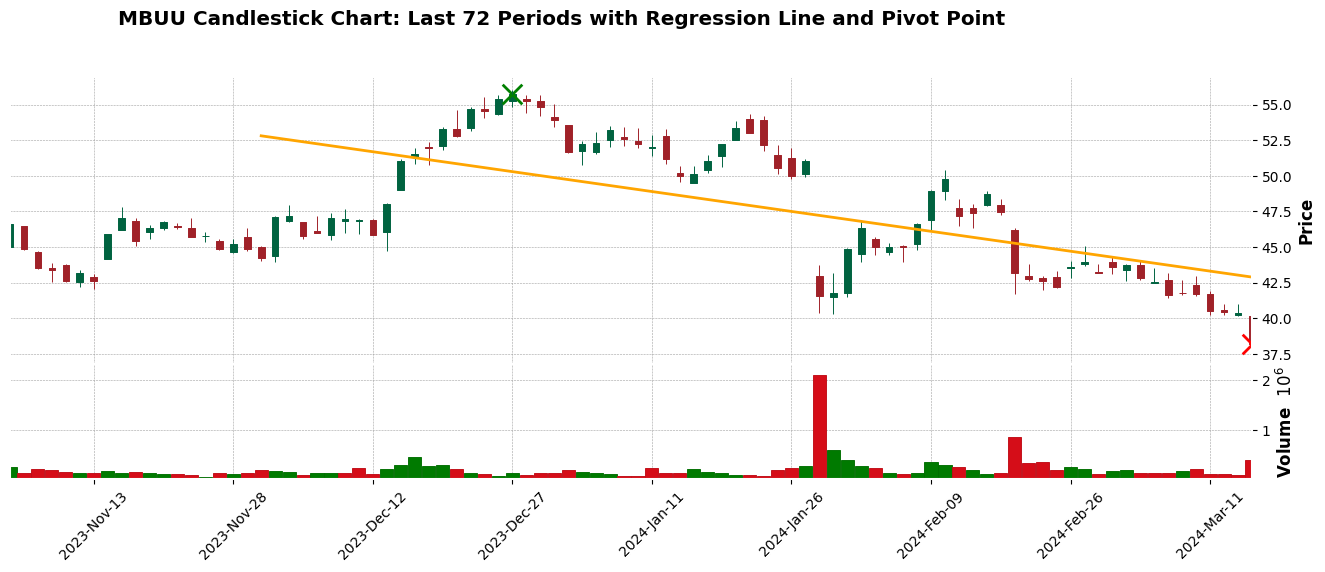

In [ ]:
# Step X: chart it
last_72_index = ticker_df.index[-90] # 90 periods on the x-axis

mpf.plot(ticker_df,
         type='candle',
         style='charles',
         volume=True,
         title=f'{ticker} Candlestick Chart: Last 72 Periods with Regression Line and Pivot Point',
         figratio=(42, 14),
         xlim=(last_72_index, ticker_df.index[-1]),  # Adjusted for the last 72 periods
         addplot=apds)

mpf.show()


50DSMA - needed bc everyone has it
standard deviations (2 above)
63DMA - makes at least more sense (63 trading days in a quarter)
2dVWAP
3dVWAP
AVWAP

| Dataframe -> .csv file |
|-|

In [ ]:
# # create a csv file with a flat date index (otherwise it'll get lost when saving to csv)
# ticker_csv_df = ticker_df.reset_index()
# # dtype of date
# print(ticker_csv_df['date'].dtype)
# # print index type
# print(ticker_csv_df.index.dtype)

# # save to csv
# ticker_csv_df.to_csv(f'{ticker}_historical_data{today_date_str}', index=False)

# ticker_csv_df.head(2)


In [ ]:
# #### add VWAP to df
# chart_historical_df['VWAP'] = (chart_historical_df['volume'] * (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3).cumsum() / chart_historical_df['volume'].cumsum()

# chart_historical_df.head(4)

In [ ]:
# """SIMPLE MOVING AVERAGES (SMA)"""
# def calculate_sma(dataframe, period):
#     return dataframe['close'].rolling(window=period).mean()

# chart_historical_df['SMA5'] = calculate_sma(chart_historical_df, 5)
# chart_historical_df['SMA10'] = calculate_sma(chart_historical_df, 10)
# chart_historical_df['SMA15'] = calculate_sma(chart_historical_df, 15)

# chart_historical_df.tail(10)


In [ ]:
# """EXPONENTIAL MOVING AVERAGES (EMA)"""
# def calculate_ema(dataframe, period):
#     return dataframe['close'].ewm(span=period, adjust=False).mean()

# # calculate EMAs for the specified periods
# chart_historical_df['EMA5'] = calculate_ema(chart_historical_df, 5)
# chart_historical_df['EMA10'] = calculate_ema(chart_historical_df, 10)
# chart_historical_df['EMA20'] = calculate_ema(chart_historical_df, 20)
# chart_historical_df['EMA50'] = calculate_ema(chart_historical_df, 50)

# chart_historical_df.tail(10)


In [ ]:
# """MOVING AVERAGE CONVERGENCE DIVERGENCE (MACD)"""
# # calculate the MACD line and the Signal line
# chart_historical_df['MACD'] = calculate_ema(chart_historical_df, 12) - calculate_ema(chart_historical_df, 26)
# chart_historical_df['MACD_Signal'] = chart_historical_df['MACD'].ewm(span=9, adjust=False).mean()

# # MACD Histogram -> useful for visualizing momentum and potential buy/sell signals
# chart_historical_df['MACD_Histogram'] = chart_historical_df['MACD'] - chart_historical_df['MACD_Signal']

# chart_historical_df.tail(10)

In [ ]:
# #### DEV - DATA ORGANIZATION ####
# chart_historical_df.columns

In [ ]:
# """BOLLINGER BANDS (BB)"""
# # BB 1 of 2 -> standard bollinger bands (20D CLOSE $)
# period = 20 # SMA periods
# std_dev_multiplier = 2 # standard deviation multiplier

# # line 1: middle band -> simple moving average (SMA)
# chart_historical_df[f'middle_band_SMA{period}'] = chart_historical_df['close'].rolling(window=period).mean()

# # not a line: standard deviation -> used to calculate the upper and lower bands
# chart_historical_df[f'std_dev_SMA{period}'] = chart_historical_df['close'].rolling(window=period).std()

# # lines 2 & 3: upper and lower bands
# chart_historical_df[f'upper_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] + (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)
# chart_historical_df[f'lower_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] - (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)


# # BB 2 of 2 -> typical price bollinger bands (20D TYPICAL $)
# chart_historical_df['typical_price'] = (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3

# # Calculate the SMA of the Typical Price and name it 'middle_band_typical_SMA20'
# chart_historical_df[f'middle_band_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).mean()

# # Calculate the standard deviation of the Typical Price
# chart_historical_df[f'std_dev_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).std()

# # Calculate the upper and lower bands for the Typical Price and name them accordingly
# chart_historical_df[f'upper_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] + (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)
# chart_historical_df[f'lower_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] - (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)

# # view df with new (2) BBs (6 new columns)
# # chart_historical_df.iloc[-1] # last row slice to check the new columns
# chart_historical_df.tail(2)


In [ ]:
# chart_historical_df.head(5)

In [ ]:
# # drop rows that contain NAs (pulled extra data earlier for this purpose)
# chart_historical_df = chart_historical_df.dropna()

# # view the df
# chart_historical_df.head(5)

In [ ]:
# # date column check data type
# chart_historical_df.index

In [ ]:
# # IMPORTANT: reset index before saving to Excel (need this shit flat so we don't lose the 'date' index)
# chart_historical_df.reset_index(inplace=True)

In [ ]:
# chart_historical_df.index

In [ ]:
# chart_historical_df.head(5)

In [ ]:
# print(tv_L2_df.columns)

In [ ]:
# # takes the original DataFrame and a list of stock symbols,
# # returns a dictionary of DataFrames, one for each stock symbol
# def create_symbol_dataframes(df, symbols):
#     symbol_dfs = {}
#     for symbol in symbols:
#         # Filter the DataFrame for the symbol and store it in a dictionary
#         symbol_dfs[f"{symbol}_chart_df"] = df[df['symbol'] == symbol]
    
#     return symbol_dfs


# symbols = mvp_chart_df['symbol'].unique() 
# symbol_dataframes = create_symbol_dataframes(mvp_chart_df, symbols)

# mtn_df = symbol_dataframes['MTN_chart_df']

# print(symbol_dataframes)



| CALCULATIONS - J. Welles Wilder Jr (technical indicators) |
|-|
| *displayed underneath the chart not overlayed* |
| START |

In [ ]:
# """RELATIVE STRENGTH INDEX (RSI)"""
# def calculate_rsi(dataframe, periods=14):
#     close_delta = dataframe['close'].diff()
#     up = close_delta.clip(lower=0)
#     down = -1 * close_delta.clip(upper=0)

#     ma_up = up.rolling(window=periods).mean()
#     ma_down = down.rolling(window=periods).mean()

#     rsi = ma_up / (ma_up + ma_down) * 100
#     return rsi

# # Adding the RSI to your DataFrame
# chart_historical_df['RSI'] = calculate_rsi(chart_historical_df)

# chart_historical_df.tail(10)


In [ ]:
# """AVERAGE TRUE RANGE (ATR)"""
# def calculate_atr(dataframe, period=14):
#     high_low = dataframe['high'] - dataframe['low']
#     high_close = (dataframe['high'] - dataframe['close'].shift()).abs()
#     low_close = (dataframe['low'] - dataframe['close'].shift()).abs()

#     # Calculate the True Range (TR) as the maximum of the three measures
#     tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

#     # Calculate the ATR by taking the rolling mean of the TR
#     atr = tr.rolling(window=period).mean()
    
#     return atr

# # Adding the ATR to your DataFrame
# chart_historical_df['ATR'] = calculate_atr(chart_historical_df)

# chart_historical_df.tail(10)

In [ ]:
# START HERE
# see about if i should be doing a multi-index and group by if it makes the code more efficient and accurate and all that
# simple data plot soon to see what we are working with and if there are bugs

In [ ]:
"""Average Directional Index (ADX)"""

'Average Directional Index (ADX)'

In [ ]:
"""PARABOLIC SAR (PSAR)"""

'PARABOLIC SAR (PSAR)'

| J. Welles Wilder Jr (technical indicators) |
|-|
| END |

In [ ]:
# LINE LEVELS not full calculation dataframe
# part 1 was calculations append
# part 2 is data points append
# part 3 extra - could be plotting past signals (might integrate ai in here like tensorflow)

| CHARTS |
|-|

In [ ]:
# #### xlwings -> dynamic send to excel ####
# # save name for todays returend gap up stocks historical data
# chart_data_file = f'chart_data{today_date_str}.xlsx'

# # reset index before saving to Excel (need
# chart_historical_df.reset_index(inplace=True, drop=True)

# # Save the DataFrame to an Excel file
# chart_historical_df.to_excel(chart_data_file, index=False)

# # Use xlwings to open the file in Excel
# app = xw.App(visible=True)
# book = app.books.open(chart_data_file)

In [ ]:
# # AVAILABLE COLS
# chart_historical_df.columns

In [ ]:
# def plot_symbol_technicals(chart_historical_df, symbol):
#     # FILTER
#     symbol_df = chart_historical_df[chart_historical_df['symbol'] == symbol].copy()
    
#     # print(symbol_df.head(5))
#     # DATA PREP
#     add2plot = [
#         # mpf.make_addplot(symbol_df['SMA5'], color='#7BAFD4', width=1.0, label='SMA5'), 
#         # mpf.make_addplot(symbol_df['SMA10'], color='#003087', width=1.0, label='SMA10'), 
#         mpf.make_addplot(symbol_df['VWAP'], color='#B31B1B', width=1.0, label='VWAP')
#     ]
    
#     # STYLE & PLOT
#     mpf_style = mpf.make_mpf_style(base_mpf_style='nightclouds', rc={'text.color': 'white'})
#     fig, axes = mpf.plot(symbol_df,
#                          type='candle',
#                          addplot=add2plot,
#                          volume=True,
#                          style=mpf_style,
#                         #  style='yahoo',
#                          figratio=(42, 12),
#                          title=f'${symbol} - Historical Data (4 Months)',
#                          tight_layout=True,
#                          returnfig=True)

#     # watermark
#     fig.text(0.5, 0.5, symbol, fontsize=50, color='gray', alpha=0.5, ha='center', va='center', rotation=0, transform=fig.transFigure)

#     mpf.show()


In [ ]:
# # print a list of the unique stock symbols
# unique_symbols = chart_historical_df['symbol'].unique()
# print(f'Unique stock symbols: {unique_symbols}')

In [ ]:
# #### EXECUTE CHARTING ####
# # DEV
# plot_symbol_technicals(chart_historical_df, 'GRND')

# # # PRO
# # for unique in unique_symbols:
# #     plot_symbol_technicals(chart_historical_df, unique)

| TREND LINES |
|-|
| Trend Lines Algorithm |

In [ ]:
# # check the date column type
# chart_historical_df.index

In [ ]:
# print(f'Unique stock symbols: {unique_symbols}')

In [ ]:
# tl_pre_df = chart_historical_df[chart_historical_df['symbol'] == 'GRND']
# tl_pre_df = tl_pre_df.iloc[:,:6]

# tl_pre_df.head(5)

In [ ]:
# # get the date column type
# tl_pre_df.index

In [ ]:

# tl_pre_df.reset_index(inplace=True)
# # save to .xlsx using xlwings
# tl_pre_file = f'tl_pre_file.xlsx'
# tl_pre_df.to_excel(tl_pre_file, index=False)

# # save df to csv
# tl_pre_df.to_csv(f'tl_pre_file.csv', index=False)
# # open the file in Excel
# # app = xw.App(visible=True)
# # book = app.books.open(tl_pre_file)

In [ ]:
# # convert to the datetime type
# tl_pre_df.index = pd.to_datetime(tl_pre_df.index)

# tl_pre_df.head(5)

| END OF IN PROGRESS WORK - NOTES BELOW |
|--|

In [ ]:
""" 
ISSUE: some weird shit with the style param
nbd tho ctfo. 

workaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  
the blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style
experienced similar shit like this years ago, idunno will get to it.

"""

' \nISSUE: some weird shit with the style param\nnbd tho ctfo. \n\nworkaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  \nthe blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style\nexperienced similar shit like this years ago, idunno will get to it.\n\n'

In [ ]:
# you're going to need different charts, one for the pre-market, and at least another for market open
# I'd like market opens to be a live feed but really we might already be in trading view watching the pine script execute

# Trend lines

In [ ]:
# but first start with getting lines on that chart with STRV
# let's get those key levels with an output on them and figure out your strategy
# figure out when fibonacci extensions get activated
# i see one view with a grid layout of the stock charts above or below them the summary with the key levels, current price and all that
# i also see a view where when looking at individiual stocks we got data all over that shit. idgaf if it's "confusing for the user"

# you have your key_levels_df
# so start next from there okay

#### </b> ####

# make title more symetrically bigger not just bigger for fucks sake 
# move price to the right side, keep vol on left
# see if you can get a marker or military like custom google font one of the ones you like
# better yet use that program you wrote for sn logos actually to create your shit
# could put that Sans Peur Systems somewhere at least watermark it, maybe?
# key levels find up to 6?, scoring strategy?, then base allotment of position (1/3, 1/5) conditionally?
# we could add RSI down there, fuck could add ichimoku, do whatever with all this data access now

NOTES -> SMA Legend

In [ ]:
# # SMA20, SMA50, and SMA200 has to be in 'dell_df'
# legend_info = {
#     'Indicator': ['SMA20', 'SMA50', 'SMA200'],
#     'Color': ['blue', 'orange', 'green'],
#     'Description': ['20-day Moving Average', '50-day Moving Average', '200-day Moving Average']
# }

# legend_df = pd.DataFrame(legend_info)
# print(legend_df)


NOTES -> custom mplfinance chart setup example

In [ ]:
# """    
# Custom Theme setup
# """

# dark_style = mpf.make_mpf_style(base_mpf_style='charles', 
#                                 rc={'axes.facecolor': 'black',
#                                     'figure.facecolor': 'darkslategrey',
#                                     'axes.grid': True,
#                                     'grid.color': 'gray',
#                                     'grid.linestyle': '--',
#                                     'grid.linewidth': 0.6,
#                                     'axes.titlesize': 16,
#                                     'axes.titleweight': 'bold',
#                                     'axes.labelsize': 12,
#                                     'axes.labelweight': 'bold',
#                                     'axes.labelcolor': 'white',
#                                     'axes.edgecolor': 'white',
#                                     'axes.linewidth': 2,
#                                     'xtick.color': 'white',
#                                     'xtick.labelsize': 10,
#                                     'ytick.color': 'white',
#                                     'ytick.labelsize': 10,
#                                     'figure.titlesize': 18,
#                                     'figure.titleweight': 'bold',
#                                     'legend.facecolor': 'grey',
#                                     'legend.edgecolor': 'white',
#                                     'legend.fontsize': 10,
#                                     'legend.title_fontsize': 12})

# mpf.plot(strv_df, 
#          type='candle', 
#          style=dark_style,  # Using the custom dark style
#          volume=True, 
#          title='STRV Candlestick Chart',
#          mav=(20, 50, 200),  # Adding moving averages of 20, 50, and 200 periods
#          figratio=(15, 8), 
#          tight_layout=True)

In [ ]:
# i need a math checker for trading days vs calendar days (252/365)

Notes -> yahoo finance API exaple (free) *with limitations

In [ ]:
# import yfinance as yf
# from datetime import datetime, timedelta

In [ ]:
# # yahoo finance data download
# start = datetime.now() - timedelta(days=60)
# end = datetime.now()
# yahoo_df = yf.download(gap_up_stocks_list, start, end)
# yahoo_df = yahoo_df.loc[:,'Close']
# # view the yahoo data yahoo finance formatting multi-index (has a 60day max with standard API maneuvers)
# yahoo_df.head(10)